In [4]:
import pandas as pd
import requests

# Wikipedia URL
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Identify yourself per Wikipedia's guidelines
email = "mheat21@byu.edu"
ua = f"STAT386-class-scraper/1.0 (+{email})"

# Fetch HTML with headers
r = requests.get(url, headers={"User-Agent": ua, "From": email}, timeout=15)
r.raise_for_status()

# Parse tables from the *HTML content*, not the URL
tables = pd.read_html(r.text)

# The first table is the S&P 500 companies list
wiki_df = tables[0]

# Keep and rename key columns
wiki_df = wiki_df[['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry']]
wiki_df.columns = ['Ticker', 'Company', 'Sector', 'SubIndustry']

# Check shape and sample
print(wiki_df.shape)  # Expect (500, 4)
print(wiki_df.head())


(503, 4)
  Ticker              Company                  Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                      SubIndustry  
0        Industrial Conglomerates  
1               Building Products  
2           Health Care Equipment  
3                   Biotechnology  
4  IT Consulting & Other Services  


/var/folders/l9/dtywcq4x0_n3zd8mjfr26ttm0000gn/T/ipykernel_75753/3070820117.py:16: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(r.text)


In [ ]:
import yfinance as yf
import pandas as pd

# Use Wikipedia df
tickers = wiki_df['Ticker'].replace({'BRK.B': 'BRK-B', 'BF.B': 'BF-B'}).tolist()

# Download Yahoo data
data = yf.download(tickers, period="1d", group_by='ticker', threads=True, progress=False)


/var/folders/l9/dtywcq4x0_n3zd8mjfr26ttm0000gn/T/ipykernel_75753/3829737353.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period="1d", group_by='ticker', threads=True, progress=False)


In [9]:
import time

records = []

for t in tickers:
    try:
        stock = yf.Ticker(t)
        info = stock.info

        current_price = info.get("currentPrice")
        prev_close = info.get("previousClose")

        # Calculate percent change safely
        if current_price is not None and prev_close is not None and prev_close != 0:
            pct_change = (current_price - prev_close) / prev_close * 100
        else:
            pct_change = None

        records.append({
            "Ticker": t,
            "CompanyName_Yahoo": info.get("shortName"),
            "MarketCap": info.get("marketCap"),
            "CurrentPrice": current_price,
            "PreviousClose": prev_close,
            "DividendYield": info.get("dividendYield"),
            "PercentChange": pct_change
        })

        # polite delay to avoid throttling
        time.sleep(0.5)

    except Exception as e:
        print(f"Failed {t}: {e}")


In [10]:
yahoo_df = pd.DataFrame(records)

# Merge with Wikipedia dataframe
merged_df = pd.merge(wiki_df, yahoo_df, on="Ticker", how="left")

# sort by Dividend Yield (highest first)
merged_df = merged_df.sort_values(by="DividendYield", ascending=False)

# Display a sample
print(merged_df.head())

    Ticker                          Company                  Sector  \
294    LYB                   LyondellBasell               Materials   
14     ARE  Alexandria Real Estate Equities             Real Estate   
116    CAG                   Conagra Brands        Consumer Staples   
21      MO                           Altria        Consumer Staples   
471     VZ                          Verizon  Communication Services   

                               SubIndustry                CompanyName_Yahoo  \
294                    Specialty Chemicals     LyondellBasell Industries NV   
14                            Office REITs  Alexandria Real Estate Equities   
116                 Packaged Foods & Meats             ConAgra Brands, Inc.   
21                                 Tobacco               Altria Group, Inc.   
471  Integrated Telecommunication Services      Verizon Communications Inc.   

        MarketCap  CurrentPrice  PreviousClose  DividendYield  PercentChange  
294  1.364098e+10  

In [11]:
merged_df.shape
merged_df.info()
merged_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, 294 to 500
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ticker             503 non-null    object 
 1   Company            503 non-null    object 
 2   Sector             503 non-null    object 
 3   SubIndustry        503 non-null    object 
 4   CompanyName_Yahoo  501 non-null    object 
 5   MarketCap          500 non-null    float64
 6   CurrentPrice       500 non-null    float64
 7   PreviousClose      501 non-null    float64
 8   DividendYield      406 non-null    float64
 9   PercentChange      500 non-null    float64
dtypes: float64(5), object(5)
memory usage: 43.2+ KB


,MarketCap,CurrentPrice,PreviousClose,DividendYield,PercentChange
count,5.000000e+02,500.000000,501.000000,406.000000,500.000000
mean,1.263590e+11,224.890910,225.751479,2.368202,-0.743487
std,4.218144e+11,458.664824,457.647035,1.682993,2.543792
min,6.607467e+09,8.220000,8.070000,0.020000,-17.453782
25%,1.992260e+10,69.045000,69.620000,1.070000,-1.808341
50%,3.674885e+10,131.660000,133.750000,1.990000,-0.601789
75%,8.351085e+10,243.230000,246.490000,3.367500,0.305607
max,4.579184e+12,7195.050000,7181.870000,11.840000,23.125565


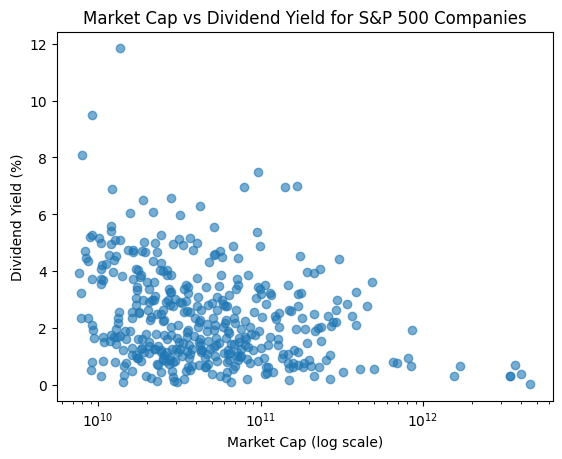

In [ ]:
import matplotlib.pyplot as plt

# Top dividend yielders
merged_df.nlargest(10, "DividendYield")[["Ticker", "Company", "Sector", "DividendYield"]]

# Average dividend yield by sector
merged_df.groupby("Sector")["DividendYield"].mean().sort_values(ascending=False)

# Market cap summary
merged_df["MarketCap"].describe()

# Scatter plot: Market Cap vs Dividend Yield
plt.scatter(merged_df["MarketCap"], merged_df["DividendYield"], alpha=0.6)
plt.xscale("log")
plt.xlabel("Market Cap (log scale)")
plt.ylabel("Dividend Yield (%)")
plt.title("Market Cap vs Dividend Yield for S&P 500 Companies")
plt.show()


In [13]:
merged_df.to_csv("sp500_merged.csv", index=False)